In [4]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter

# Read data, explore target

In [5]:
data = pd.read_excel("220626_chocolate_bar_rating.xlsx")
data.columns = [
    "ref",
    "company_manufacturer",
    "company_location",
    "review_date",
    "country_of_bean_origin",
    "specific_bean_origin_or_bar_name",
    "cocoa_percent",
    "ingredients",
    "most_memorable_characteristics",
    "rating",
]
# data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-18/chocolate.csv")
data

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50
...,...,...,...,...,...,...,...,...,...,...
2583,1205,Zotter,Austria,2014,Blend,Raw,80%,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75
2584,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75%,"3- B,S,C","strong nutty, marshmallow",3.75
2585,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75%,"3- B,S,C","fatty, earthy, cocoa",3.00
2586,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70%,"3- B,S,C","fatty, mild nuts, mild fruit",3.25


In [91]:
# format plots for Latex
font = {"family": "Times New Roman", "size": 18}
plt.rc("font", **font)

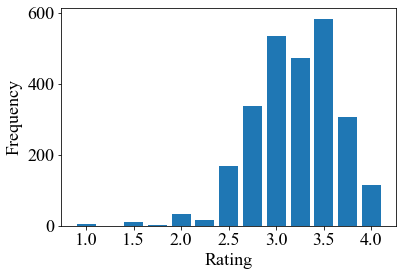

In [92]:
rating_counts = data["rating"].value_counts()
plt.bar(rating_counts.index, rating_counts, width=0.2)
plt.xticks(np.arange(1,4.5,0.5))
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig("figures/ratings_hist.pdf", bbox_inches="tight")
plt.show()

# Data exploration

In [8]:
categorical_features = [
    "company_manufacturer",
    "company_location",
    "review_date",
    "country_of_bean_origin",
    "specific_bean_origin_or_bar_name",
    "ingredients",
    "most_memorable_characteristics",
]

pd.DataFrame(
    {
        "categories": data.loc[:, categorical_features].apply(
            lambda x: len(x.unique())
        ),
        "only occurs once": [
            sum(data.loc[:, col].value_counts() == 1) for col in categorical_features
        ],
    }
)

,categories,only occurs once
company_manufacturer,593,155
company_location,65,5
review_date,17,0
country_of_bean_origin,63,11
specific_bean_origin_or_bar_name,1643,1423
ingredients,22,3
most_memorable_characteristics,2545,2511


## Company Manufacturer

In [9]:
manufacturer_shares = data["company_manufacturer"].value_counts() / len(data)
manufacturer_shares#.iloc[0:65,]

Soma                                  0.022025
Fresco                                0.015070
Arete                                 0.012365
Bonnat                                0.011592
A. Morin                              0.011206
                                        ...   
Rococo (Grenada Chocolate Co.)        0.000386
Cacao Arabuco                         0.000386
Britarev                              0.000386
Love Bar                              0.000386
Chocolates by Josh (Box Chocolate)    0.000386
Name: company_manufacturer, Length: 593, dtype: float64

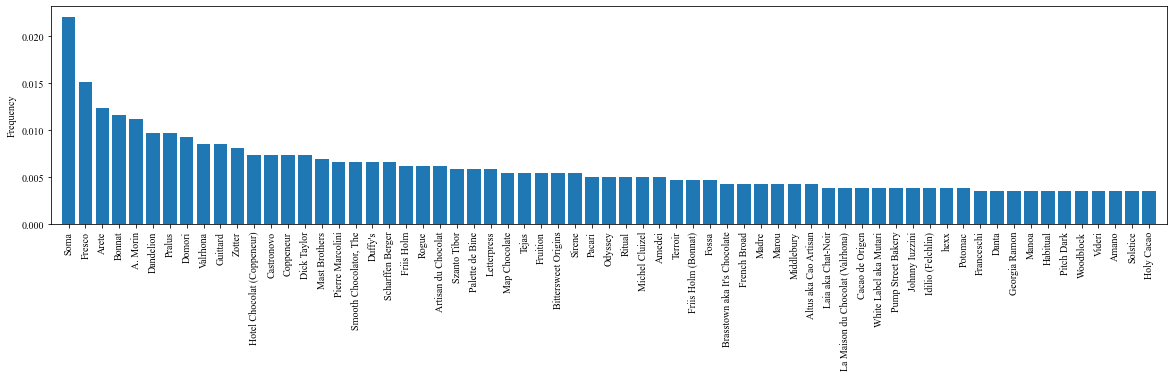

In [10]:
shares = manufacturer_shares.iloc[0:65]
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(shares.index, shares)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/company_manufacturer_barplot.pdf", bbox_inches="tight")
plt.show()

## Company Location

In [11]:
location_shares = data["company_location"].value_counts() / len(data)
location_shares

U.S.A.                   0.451314
France                   0.069165
Canada                   0.068779
U.K.                     0.051777
Italy                    0.030526
                           ...   
St.Vincent-Grenadines    0.000386
Wales                    0.000386
Martinique               0.000386
Ghana                    0.000386
Suriname                 0.000386
Name: company_location, Length: 65, dtype: float64

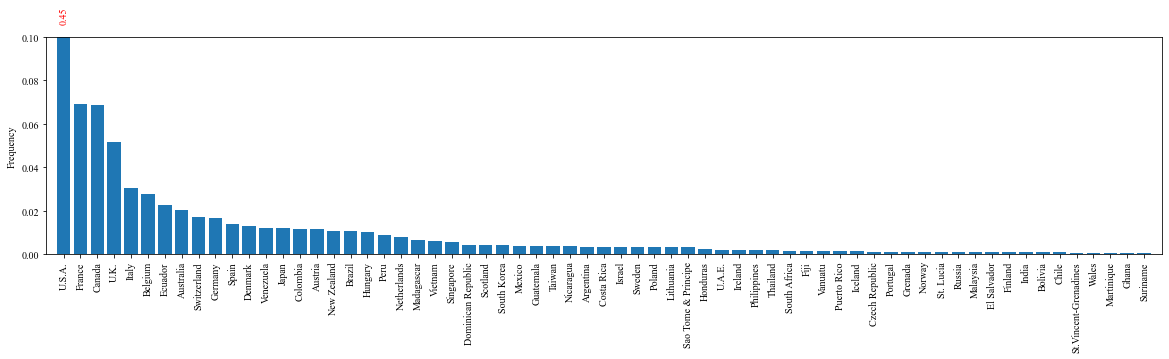

In [12]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(location_shares.index, location_shares)
ax.set_ylim(0, 0.1)

h_usa = f"{round(bars[0].get_height(),2)}"
ax.text(
    bars[0].get_x() + 0.1, 0.11, s=h_usa, ha="left", va="center", rotation=90, c="red"
)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/company_location_barplot.pdf", bbox_inches="tight")
plt.show()

In [13]:
# number of company locations that make up 80% of the observations
len(location_shares.loc[location_shares.cumsum() <= 0.8].index)

11

## Review Date

In [14]:
date_freq = data["review_date"].value_counts().sort_index()

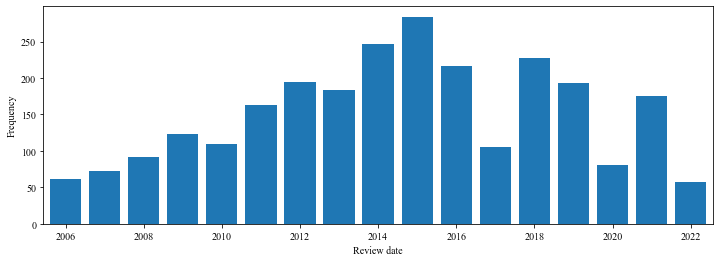

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(date_freq.index, date_freq)

plt.margins(0.01, 0.05)
plt.xlabel("Review date")
plt.ylabel("Frequency")
plt.show()

## Country of Bean Origin

In [16]:
origin_shares = data["country_of_bean_origin"].value_counts() / len(data)
origin_shares

Venezuela             0.098145
Peru                  0.095827
Dominican Republic    0.090417
Ecuador               0.086167
Madagascar            0.071097
                        ...   
China                 0.000386
Principe              0.000386
Sulawesi              0.000386
Suriname              0.000386
DR Congo              0.000386
Name: country_of_bean_origin, Length: 63, dtype: float64

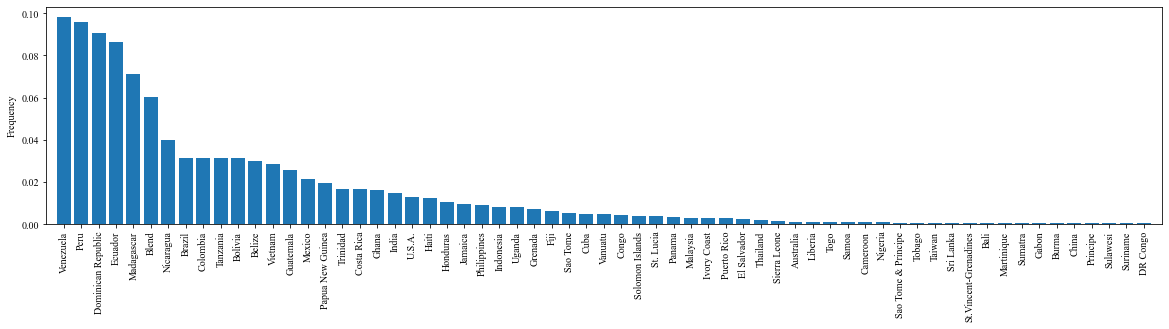

In [17]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(origin_shares.index, origin_shares)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/bean_origin_barplot.pdf", bbox_inches="tight")
plt.show()

## Cocoa Percent

In [18]:
cocoa_percent = data.loc[:, "cocoa_percent"].apply(lambda x: float(x[:-1]))
print(cocoa_percent.min())
print(cocoa_percent.max())

42.0
100.0


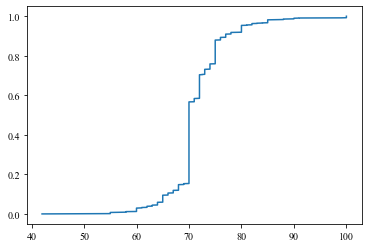

In [19]:
ecdf_percent = ECDF(cocoa_percent)
plt.plot(ecdf_percent.x, ecdf_percent.y)

## Most Memorable Characteristics

In [20]:
data["most_memorable_characteristics"]

0           rich cocoa, fatty, bready
1        cocoa, blackberry, full body
2              cocoa, vegetal, savory
3                 chewy, off, rubbery
4       milk brownie, macadamia,chewy
                    ...              
2583           waxy, cloying, vegetal
2584        strong nutty, marshmallow
2585             fatty, earthy, cocoa
2586     fatty, mild nuts, mild fruit
2587        muted, roasty, accessible
Name: most_memorable_characteristics, Length: 2588, dtype: object

In [21]:
flavours = (
    data["most_memorable_characteristics"]
    .str.replace(" and", ",")
    .str.split(",\s*|\s", expand=True)
)

flavours_list = []
for i in range(5):
    flavours_list.extend(flavours.iloc[:, i].unique())

flavours_set = set(flavours_list)
for s in ["", None]:
    flavours_set.remove(s)

In [22]:
dupes = [x for x in flavours_list if not x in ["", None]]
for i in range(6):
    print("occur >= " + str(i + 1) + "x:", len(set(dupes)))
    seen = set()
    dupes = [x for x in dupes if x in seen or seen.add(x)]
    if i == 3:
        print(dupes)

occur >= 1x: 578
occur >= 2x: 308
occur >= 3x: 218
occur >= 4x: 135
['fatty', 'nutty', 'fruit', 'banana', 'earthy', 'sandy', 'sour', 'rubber', 'roasty', 'musty', 'cocoa', 'mint', 'creamy', 'notes', 'tart', 'vanilla', 'leather', 'coffee', 'roast', 'brownie', 'anise', 'sweet', 'off', 'berry', 'base', 'dried', 'sticky', 'floral', 'butter', 'licorice', 'nuts', 'burnt', 'spice', 'citrus', 'woody', 'molasses', 'strawberry', 'melon', 'nut', 'intense', 'rich', 'orange', 'choco', 'rubbery', 'lemon', 'smoke', 'ashey', 'harsh', 'spicy', 'grits', 'bitter', 'grassy', 'vegetal']
occur >= 5x: 53
occur >= 6x: 0


In [23]:
flavours_df = pd.Series(flavours_list).dropna()
flavours_df[flavours_df.str.contains("nut")].unique()

array(['nutty', 'nut', 'nuts', 'nutmeg', 'hazelnut', 'peanut', 'coconut',
       'cocounut', 'walnut', 'walnuts', 'peanutbutter', 'nutella'],
      dtype=object)

In [24]:
flavours_df = pd.Series(flavours_list).dropna()
flavours_df[flavours_df.str.contains("choc")].unique()

array(['chocolate', 'choco', 'chocolatey', 'chocolaty'], dtype=object)

### Autocorrect

In [1]:
from autocorrect import Speller
from spellchecker import SpellChecker

In [24]:
spell = Speller()
for f in flavours_set:
    f_corr = spell(f)
    if f != f_corr:
        print(f, "->", f_corr)

mocha -> mecha
rubbery -> rubber
bready -> ready
prunes -> runes
spiciness -> sickness
chalky -> chalk
raisiny -> raising
choco -> coco
fudge-like -> judge-like
unripe -> unlike
burlap -> burial
spciy -> spicy
walnuts -> walnut
papaya -> papal
intens -> intent
rancid -> rcid
chocolaty -> chocolate
earthy -> earth
tangy -> tango
ashey -> ashes
sugary -> sugar
raisins -> raising
powdery -> powder
pungent -> urgent
sourness -> sources
roaste -> roasted
roaster -> roster
minty -> mint
smokey -> smoke
earty -> party
nibby -> lobby
unrecognizable -> recognizable
charred -> charged
descript -> script
cheesey -> cheese
roasty -> roast
carame -> came
leathery -> leather
nibs -> nis
raisin -> raising
licoric -> iconic
undertone -> undergone
astringnet -> stringent
plums -> plus
smomkey -> smoke
pastey -> paste
lavendar -> lavender
toffee -> coffee
petro -> metro
klingy -> king
sligt -> slight
grainy -> grain
roasty/smokey -> roast/smoke
prononced -> pronounced
punchy -> punch
cooa -> cool
tolera

In [33]:
spell = SpellChecker()
for f in flavours_set:
    f_corr = spell.correction(f)
    if f != f_corr:
        print(f, "->", f_corr)

mouthfeel -> mouthful
descript -> describe
alkalyzed -> analyzed
roaste -> roast
sliglty -> slighty
Roasty -> roast
winey -> wine
unfixable -> unlikable
alocohol -> alcohol
dirt/ -> dirty
astringcy -> stringy
carame -> caramel
"Andes" -> andes
(fig) -> fig
raisns -> rains
sl. -> sly
ham-like -> hairlike
sl -> so
sligthly -> slightly
licoric -> licorice
astingent -> astringent
overyly -> overly
spicey -> spice
vanila -> vanilla
non-descript -> nondescript
prononced -> pronounced
hebs -> he's
earty -> party
astringency -> stringency
molassses -> molasses
cheesey -> cheese
cardamon -> cardamom
roasty -> roast
ligt -> light
rasin -> rain
smomkey -> smokey
nibby -> dibby
mildy -> mild
klingy -> clingy
XL -> al
pomegrant -> pomegranate
cocounut -> coconut
cinamon -> cinnamon
"rolo" -> prolon
pastey -> pastry
dutched? -> ditched
sticy -> stick
lavendar -> lavender
malitol -> marital
fertilzer -> fertilizer
accesible -> accessible
brownine -> brownie
blackcherry -> blackberry
smoth -> smooth
d

In [34]:
spell.unknown(flavours_set)

{'"andes"',
 '"rolo"',
 '(fig)',
 'accesible',
 'aftertaste',
 'alkalyzed',
 'alocohol',
 'ashey',
 'astingent',
 'astringcy',
 'astringency',
 'astringnet',
 'blackcherry',
 'blackpepper',
 'bready',
 'brownine',
 'cadbury',
 'candy-like',
 'carame',
 'cardamon',
 'cheesey',
 'cinamon',
 'cocounut',
 'cooa',
 'descript',
 'dirt/',
 'dirty/burnt',
 'distinquished',
 'domintates',
 'dutched?',
 'earty',
 'fertilzer',
 'floral-spice',
 'fudge-like',
 'ham-like',
 'hebs',
 'intens',
 'klingy',
 'lavendar',
 'licoric',
 'ligt',
 'malitol',
 'mildy',
 'molassses',
 'mouthfeel',
 'nibby',
 'non-descript',
 'overyly',
 'pastey',
 'peanutbutter',
 'pomegrant',
 'prononced',
 'raisiny',
 'raisns',
 'rasin',
 'roaste',
 'roasty',
 'roasty/smokey',
 'sl',
 'sl.',
 'sliglty',
 'sligt',
 'sligthly',
 'smomkey',
 'smoth',
 'spciy',
 'spice/herb',
 'spicey',
 'sticy',
 'sublte',
 'tea-like',
 'trop.',
 'unfixable',
 'vanila',
 'vanilla(n)',
 'w/',
 'winey',
 'woody/green',
 'wtf',
 'xl'}

In [35]:
from textblob import Word

In [36]:
for f in flavours_set:
    word = Word(f)
    print(f)
    print(word.spellcheck())

medley
[('merely', 0.9043062200956937), ('madly', 0.03349282296650718), ('meddle', 0.028708133971291867), ('motley', 0.014354066985645933), ('morley', 0.004784688995215311), ('mele', 0.004784688995215311), ('meddler', 0.004784688995215311), ('eley', 0.004784688995215311)]
mouthfeel
[('mouthfeel', 0.0)]
ending
[('ending', 1.0)]
floral
[('flora', 1.0)]
uncontrolled
[('uncontrolled', 1.0)]
is
[('is', 1.0)]
walnut
[('walnut', 1.0)]
dirty/burnt
[('dirty/burnt', 0.0)]
leather
[('leather', 1.0)]
earthy
[('earthy', 1.0)]
descript
[('rescript', 1.0)]
watery
[('watery', 1.0)]
pungent
[('pungent', 1.0)]
acidity
[('aridity', 1.0)]
well
[('well', 1.0)]
atypical
[('typical', 1.0)]
slow
[('slow', 1.0)]
oranges
[('oranges', 1.0)]
multiple
[('multiple', 1.0)]
some
[('some', 1.0)]
brown
[('brown', 1.0)]
leathery
[('leathery', 1.0)]
ripe
[('ripe', 1.0)]
alkalyzed
[('analyzed', 1.0)]
fudge
[('judge', 0.9375), ('budge', 0.0625)]
butt
[('butt', 1.0)]
roaste
[('roast', 0.8), ('roasted', 0.2)]
mild
[('mild', 

[('Fruit', 0.2702702702702703), ('Purity', 0.24324324324324326), ('Fruits', 0.1891891891891892), ('Bruit', 0.13513513513513514), ('Rusty', 0.05405405405405406), ('Equity', 0.05405405405405406), ('Trusty', 0.04054054054054054), ('Crusty', 0.013513513513513514)]
herbal
[('verbal', 1.0)]
residue
[('residue', 1.0)]
baked
[('baked', 1.0)]
mix
[('mix', 1.0)]
basic
[('basic', 1.0)]
metal
[('metal', 1.0)]
cacao
[('canal', 0.7422680412371134), ('sacro', 0.05154639175257732), ('cargo', 0.05154639175257732), ('cava', 0.030927835051546393), ('facto', 0.020618556701030927), ('carlo', 0.020618556701030927), ('cameo', 0.020618556701030927), ('cabal', 0.020618556701030927), ('cocoa', 0.010309278350515464), ('cavae', 0.010309278350515464), ('campo', 0.010309278350515464), ('cairo', 0.010309278350515464)]
gateway
[('gateway', 1.0)]
pistachio
[('pistachio', 0.0)]
bar
[('bar', 1.0)]
fat
[('fat', 1.0)]
macadamia
[('macadamia', 0.0)]
nutmeg
[('nutmeg', 0.0)]
off
[('off', 1.0)]
true
[('true', 1.0)]
punchy
[(

KeyboardInterrupt: 

### Word stemming

In [132]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [38]:
ps = nltk.stem.SnowballStemmer("english")

In [39]:
for f in flavours_set:
    f_stem = ps.stem(f)
    if f != f_stem:
        print(f, "->", f_stem)

ending -> end
uncontrolled -> uncontrol
earthy -> earthi
watery -> wateri
acidity -> acid
atypical -> atyp
oranges -> orang
multiple -> multipl
leathery -> leatheri
alkalyzed -> alkalyz
fudge -> fudg
roaste -> roast
berry -> berri
chalky -> chalki
sliglty -> sliglti
very -> veri
musty -> musti
Fruit -> fruit
Roasty -> roasti
evolves -> evolv
unfixable -> unfix
perfectly -> perfect
crunchy -> crunchi
gentle -> gentl
waxy -> waxi
olive -> oliv
candy -> candi
tangy -> tangi
defined -> defin
strawberries -> strawberri
astringcy -> astringci
notes -> note
smokiness -> smoki
AT -> at
mildly -> mild
Fruity -> fruiti
residue -> residu
baked -> bake
punchy -> punchi
chocolaty -> chocolati
carame -> caram
"Andes" -> "andes"
grounds -> ground
unbalanced -> unbalanc
dry -> dri
raisns -> raisn
body -> bodi
spicy -> spici
issues -> issu
ambiguous -> ambigu
early -> earli
edge -> edg
peanutbutter -> peanutbutt
pasty -> pasti
cooked -> cook
muddy -> muddi
heavy -> heavi
medicine -> medicin
sugary -> s

In [133]:
for f in flavours_set:
    f_changed = WordNetLemmatizer().lemmatize(f)
    if f != f_changed:
        print(f)
        print(WordNetLemmatizer().lemmatize(f))

oats
oat
fades
fade
flavors
flavor
raspberries
raspberry
undertones
undertone
spices
spice
hints
hint
ends
end
walnuts
walnut
strawberries
strawberry
prunes
prune
issues
issue
blackberries
blackberry
molassses
mola
grits
grit
plums
plum
raisins
raisin
oranges
orange
grapes
grape
herbs
herb
less
le
dates
date
nibs
nib
grounds
ground
blueberries
blueberry
nuts
nut
berries
berry
lacks
lack
cranberries
cranberry
pieces
piece
notes
note
carrots
carrot
cherries
cherry


# Methods for Evaluation

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [27]:
def mdae(y_true, y_pred):
    return abs(y_true - y_pred).median()

In [28]:
def print_scores(y_pred_train, y_pred):
    print(
        "MSE:\t\t",
        "Train: {0:0.4f}".format(mse(y_pred_train, y_train)),
        "\tTest: {0:0.4f}".format(mse(y_pred, y_test)),
    )
    print(
        "MdAE:\t\t",
        "Train: {0:0.4f}".format(mdae(y_pred_train, y_train)),
        "\tTest: {0:0.4f}".format(mdae(y_pred, y_test)),
    )

    # retrieve closest target class from regression -> classification:
    targets = np.arange(1, 4, 0.25)  # array of target classes
    # substract all targets from each prediction
    diff_train = np.subtract.outer(y_pred_train, targets)
    diff_test = np.subtract.outer(y_pred, targets)
    # closest indices of target to prediction
    i_train = np.argmin(abs(diff_train), axis=1)
    i_test = np.argmin(abs(diff_test), axis=1)
    # get target values from indices
    y_pred_train_cat = targets[i_train].astype(str)
    y_pred_cat = targets[i_test].astype(str)

    print(
        "Accuracy:\t",
        "Train: {0:0.4f}".format(accuracy_score(y_train_cat, y_pred_train_cat)),
        "\tTest: {0:0.4f}".format(accuracy_score(y_test_cat, y_pred_cat)),
    )

In [29]:
def histogram_residuals(y_test, y_pred, model_name="some_model"):
    residuals = y_test - y_pred
    plt.hist(residuals, bins=np.arange(-2.125, 1.125, 0.25))
    plt.xticks(np.arange(-2, 1.25, 0.5))
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.savefig(f"figures/residuals_{model_name}_hist.pdf", bbox_inches="tight")
    plt.show()

In [30]:
def scatter_with_dot_size(x, y):
    c = Counter(zip(x, y))
    s = [c[(n, r)] for n, r in zip(x, y)]
    return plt.scatter(x, y, marker="o", s=s)

# Pre-processing and splitting

## Pre-processing before train test split

In [31]:
# make cocoa_percent numeric
data.loc[:, "cocoa_percent"] = (
    data.loc[:, "cocoa_percent"].apply(lambda x: float(x[:-1])) / 100
)

In [32]:
print("Missing ingredients:\t", data["ingredients"].isnull().sum())
print(
    "with cocoa percent = 1:\t",
    len(
        data.loc[
            data["ingredients"].isnull() & (data["cocoa_percent"] == 1),
            "ingredients",
        ]
    ),
)

Missing ingredients:	 87
with cocoa percent = 1:	 14


In [33]:
# replace nan ingredients
data.loc[
    data["ingredients"].isnull() & (data["cocoa_percent"] == 1),
    "ingredients",
] = "1- B"

In [34]:
# get number of ingredients
ingredients = data["ingredients"].str.split("-\s*", expand=True)
ingredients.columns = ["number_ingredients", "ingredients"]
data.loc[:, "number_ingredients"] = pd.to_numeric(
    ingredients.iloc[:, 0], errors="coerce"
)
data.loc[:, "ingredients"] = ingredients["ingredients"]

In [35]:
h = data["ingredients"].value_counts()
x = h.index
h

B,S,C           1029
B,S              738
B,S,C,L          293
B,S,C,V,L        184
B,S,C,V          141
B,S*              31
B,S*,C,Sa         20
B                 20
B,S*,C            13
B,S,L              8
B,S*,C,V           7
B,S,C,V,Sa         6
B,S,V,L            5
B,S,C,Sa           5
B,S,C,V,L,Sa       4
B,S,V              3
B,S*,V,L           3
B,S*,C,L           2
B,S*,Sa            1
B,C                1
B,S,C,L,Sa         1
Name: ingredients, dtype: int64

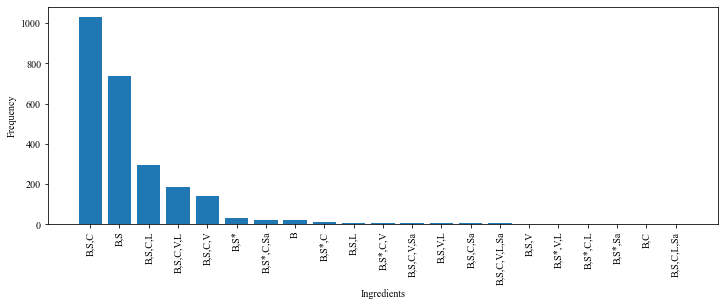

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x, h)
plt.xticks(rotation=90)
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.savefig("figures/ingredients_barplot.pdf", bbox_inches="tight")
plt.show()

## Train test split

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data.loc[:, data.columns != "rating"],
    data["rating"],
    test_size=0.15,
    random_state=1,
)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.15, random_state=1
)
y_train_cat = y_train.astype(str)
y_val_cat = y_val.astype(str)
y_test_cat = y_test.astype(str)

In [39]:
print(X_train_raw.shape)
print(y_train.shape)
print(X_val_raw.shape)
print(y_val.shape)
print(X_test_raw.shape)
print(y_test.shape)

(1869, 10)
(1869,)
(330, 10)
(330,)
(389, 10)
(389,)


## Pre-processing after train test split

In [40]:
# fill nan number_ingredients with median
median = X_train_raw.loc[
    (~X_train_raw["number_ingredients"].isnull()) & (X_train_raw["cocoa_percent"] < 1),
    "number_ingredients",
].median()
print(median)

X_train_raw.loc[
    X_train_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median
X_val_raw.loc[
    X_val_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median
X_test_raw.loc[
    X_test_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median

3.0


In [41]:
X_train_raw

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,number_ingredients
1439,1395,Lonohana,U.S.A.,2014,U.S.A.,"O'ahu Island, Haleiwa E, 2014",0.75,"B,S,C,V","dairy, pudding",4.0
1833,1415,Pacari,Ecuador,2014,Ecuador,Cumbia,0.70,"B,S,C,L","savory, smokey",4.0
170,600,Artisan du Chocolat,U.K.,2010,Vietnam,Ba Ria Vung Tau Province,0.72,"B,S,C","unrefined, distinct spicey",3.0
2461,2744,Vesta,U.S.A.,2022,Guatemala,Guatemala,0.78,"B,S*,C","rich cocoa, fruit, bitter, molasses",3.0
1308,241,Kallari (Ecuatoriana),Ecuador,2008,Ecuador,Sisa 36hr/ W. F. blend prototype,0.70,"B,S,C,V","creamy, mild marshmallow",4.0
...,...,...,...,...,...,...,...,...,...,...
2530,1042,Woodblock,U.S.A.,2013,Trinidad,"Gran Couva, batch 1",0.70,"B,S","creamy, woody, mild metallic",2.0
44,2438,Aelan,Vanuatu,2019,Vanuatu,"Malekula Island, batch M10/19",0.70,"B,S","unrefined, sweet, metallic",2.0
1930,2622,Potomac,U.S.A.,2021,Peru,"Ucayali, batch 200105",0.70,"B,S","anise, cocoa, dried fruit",2.0
1247,725,Idilio (Felchlin),Switzerland,2011,Venezuela,Coopertiva Amazona,0.72,"B,S,C","creamy, cocoa, lemon",3.0


# Feature Engineering

In [42]:
X_train = X_train_raw.copy()
X_val = X_val_raw.copy()
X_test = X_test_raw.copy()

In [43]:
features_dict = {
    "baseline": ["cocoa_percent", "number_ingredients"],
    "one_hot_encoded": {
        "company_manufacturer": [],
        "company_location": [],
        "country_of_bean_origin": [],
    },
    "target_encoded": {
        "company_manufacturer": [],
        "company_location": [],
        "country_of_bean_origin": [],
    },
    "ingredients": {"dummies": [], "number_scaled": []},
    "most_memorable_characteristics": {"50%": [], "80%": [], "95%": []},
}

## Review Date

In [44]:
dates = X_train_raw["review_date"].unique()
dates.sort()

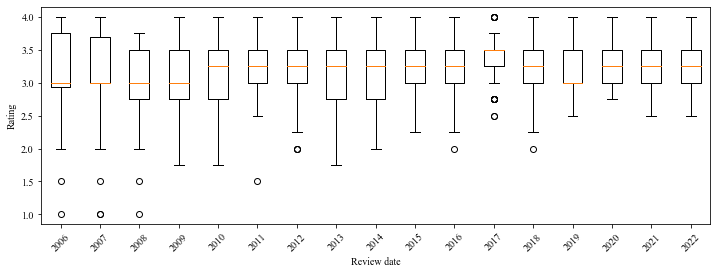

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.boxplot([y_train[X_train_raw["review_date"] == rd] for rd in dates], labels=dates)
plt.xticks(rotation=45)
plt.xlabel("Review date")
plt.ylabel("Rating")
plt.savefig("figures/review_date_boxplot.pdf", bbox_inches="tight")
plt.show()

In [46]:
# label encoding
min_date = X_train["review_date"].min()
X_train.loc[:, "review_date"] = X_train_raw.loc[:, "review_date"] - min_date
X_val.loc[:, "review_date"] = X_val_raw.loc[:, "review_date"] - min_date
X_test.loc[:, "review_date"] = X_test_raw.loc[:, "review_date"] - min_date
X_val.loc[:, "review_date"].unique()

array([ 9,  6,  3, 12, 13,  2,  8,  1, 16,  4,  5, 10, 11,  7, 15, 14,  0],
      dtype=int64)

In [47]:
X_train["review_date"].corr(y_train)

0.11431817568054758

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
lm = LinearRegression()
lm.fit(np.array(X_train["review_date"]).reshape(-1, 1), y_train)
print("intercept:\t", round(lm.intercept_, 4))
print("coefficient:\t", round(lm.coef_[0], 4))

intercept:	 3.0984
coefficient:	 0.0124


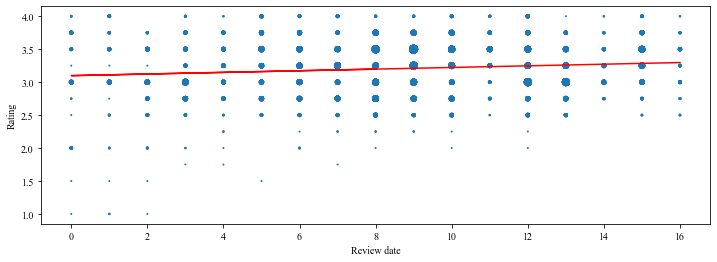

In [50]:
x = X_train["review_date"]

plt.subplots(figsize=(12, 4))
scatter_with_dot_size(x, y_train)
plt.plot(x, lm.coef_ * x + lm.intercept_, color="red")
plt.xlabel("Review date")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_review_date.pdf", bbox_inches="tight")
plt.show()

In [51]:
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_white

In [52]:
x = add_constant(np.array(X_train["review_date"]))
res = OLS(y_train, x).fit()

In [53]:
white_test = het_white(res.resid, res.model.exog)
print("LM-Test p-value:", white_test[1])  # << 0.05

LM-Test p-value: 2.13056964313503e-22


In [54]:
x = np.array(X_train["review_date"].apply(lambda x: x ^ 2))
print("correlation with rating:", pd.Series(x).corr(y_train))
X = add_constant(x)
res = OLS(y_train, X).fit()
white_test = het_white(res.resid, res.model.exog)
print("LM-Test p-value:\t", white_test[1])  # << 0.05

correlation with rating: 0.023106962375003173
LM-Test p-value:	 1.3600569063787788e-12


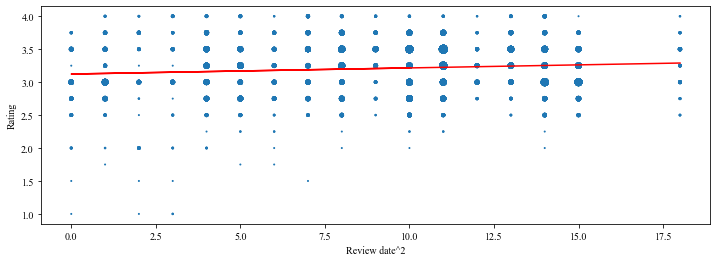

In [55]:
plt.subplots(figsize=(12, 4))
scatter_with_dot_size(x, y_train)
plt.plot(x, res.params.x1 * x + res.params.const, color="red")
plt.xlabel("Review date^2")
plt.ylabel("Rating")
plt.show()

In [56]:
x = X_train["review_date"]
y = y_train.apply(math.log)
print("correlation with rating:", x.corr(y))
X = add_constant(x)
res = OLS(y, X).fit()
white_test = het_white(res.resid, res.model.exog)
print("LM-Test p-value:\t", white_test[1])  # << 0.05

correlation with rating: 0.13730101617599713
LM-Test p-value:	 1.968918067731626e-19


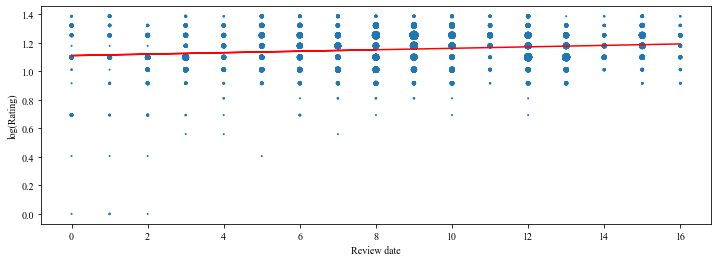

In [57]:
plt.subplots(figsize=(12, 4))
scatter_with_dot_size(x, y)
plt.plot(x, res.params.review_date * x + res.params.const, color="red")
plt.xlabel("Review date")
plt.ylabel("log(Rating)")
plt.show()

In [58]:
features_dict["baseline"] += ["review_date"]
features_dict

{'baseline': ['cocoa_percent', 'number_ingredients', 'review_date'],
 'one_hot_encoded': {'company_manufacturer': [],
  'company_location': [],
  'country_of_bean_origin': []},
 'target_encoded': {'company_manufacturer': [],
  'company_location': [],
  'country_of_bean_origin': []},
 'ingredients': {'dummies': [], 'number_scaled': []},
 'most_memorable_characteristics': {'50%': [], '80%': [], '95%': []}}

## Features with many categories

In [59]:
locations_counts = X_train["company_location"].value_counts()
locations = locations_counts.loc[locations_counts >= 25].index

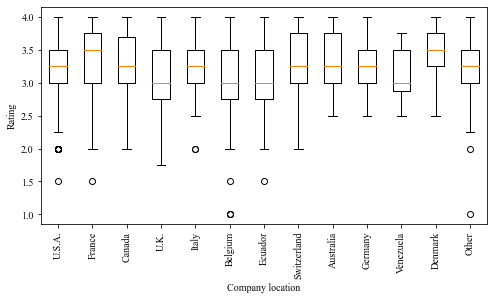

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.boxplot(
    [y_train[X_train["company_location"] == loc] for loc in locations],
    labels=locations,
    widths=0.5,
)
ax.boxplot(
    y_train[~X_train["company_location"].isin(locations)],
    positions=[len(locations) + 1],
    labels=["Other"],
    widths=0.5,
)

plt.xticks(rotation=90)
plt.xlabel("Company location")
plt.ylabel("Rating")
plt.savefig("figures/company_location_boxplot.pdf", bbox_inches="tight")
plt.show()

In [61]:
from category_encoders import OneHotEncoder, TargetEncoder

In [62]:
def apply_encoding(col_name, crit_value):
    # compute the number of observations per category
    counts = X_train_raw[col_name].value_counts()

    # find large enough categories
    categories = counts[counts > crit_value].index

    # create column where small categories are aggregated as "other"
    col_agg = col_name + "_agg"
    X_train_raw[col_agg] = X_train_raw[col_name]
    X_train_raw.loc[~X_train_raw[col_agg].isin(categories), col_agg] = "other"
    X_val_raw[col_agg] = X_val_raw[col_name]
    X_val_raw.loc[~X_val_raw[col_agg].isin(categories), col_agg] = "other"
    X_test_raw[col_agg] = X_test_raw[col_name]
    X_test_raw.loc[~X_test_raw[col_agg].isin(categories), col_agg] = "other"

    # one hot encoding
    encoder_oh = OneHotEncoder(cols=col_agg, use_cat_names=True)
    encoded_oh_train = encoder_oh.fit_transform(X_train_raw, y_train)
    encoded_oh_val = encoder_oh.transform(X_val_raw)
    encoded_oh_test = encoder_oh.transform(X_test_raw)
    cols_enc_oh = [
        name
        for name in filter(
            lambda x: x.startswith(col_agg) & ~x.endswith("other"),
            encoded_oh_train.columns,
        )
    ]
    X_train[cols_enc_oh] = encoded_oh_train[cols_enc_oh]
    X_val[cols_enc_oh] = encoded_oh_val[cols_enc_oh]
    X_test[cols_enc_oh] = encoded_oh_test[cols_enc_oh]
    features_dict["one_hot_encoded"][col_name] = cols_enc_oh

    # target encoding
    encoder_t = TargetEncoder(
        cols=col_name, handle_unknown="value", min_samples_leaf=20, smoothing=10
    )
    encoded_t_train = encoder_t.fit_transform(X_train_raw, y_train)
    encoded_t_val = encoder_t.transform(X_val_raw)
    encoded_t_test = encoder_t.transform(X_test_raw)
    X_train[col_name + "_encoded_t"] = encoded_t_train[col_name]
    X_val[col_name + "_encoded_t"] = encoded_t_val[col_name]
    X_test[col_name + "_encoded_t"] = encoded_t_test[col_name]
    features_dict["target_encoded"][col_name] = col_name + "_encoded_t"

In [63]:
apply_encoding("company_manufacturer", crit_value=25)
apply_encoding("company_location", crit_value=25)
apply_encoding("country_of_bean_origin", crit_value=50)

In [64]:
# percentage of observations where company location and country of bean origin coincide
len(
    X_train.loc[
        X_train["company_location"] == X_train["country_of_bean_origin"],
    ]
) / len(X_train)

0.12627073301230604

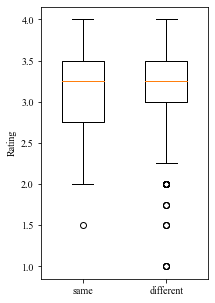

In [65]:
fig, ax = plt.subplots(figsize=(3, 5))

ax.boxplot(
    y_train[X_train["company_location"] == X_train["country_of_bean_origin"]],
    positions=[0],
    labels=["same"],
    widths=0.5,
)
ax.boxplot(
    y_train[X_train["company_location"] != X_train["country_of_bean_origin"]],
    positions=[1],
    labels=["different"],
    widths=0.5,
)

plt.ylabel("Rating")
plt.savefig("figures/location_vs_bean_origin.pdf", bbox_inches="tight")
plt.show()

## Ingredients

In [66]:
index_missing_train = X_train_raw.loc[
    X_train_raw["ingredients"].isnull(),
].index
index_missing_val = X_val_raw.loc[
    X_val_raw["ingredients"].isnull(),
].index
index_missing_test = X_test_raw.loc[
    X_test_raw["ingredients"].isnull(),
].index
len(index_missing_test) + len(index_missing_val) + len(index_missing_train)

73

In [67]:
ingredients_list = ["sugar", "sweetener", "cocoa_butter", "vanilla", "lecithin", "salt"]
ingredients_abbrev = ["S,", "S\*", "C", "V", "L", "Sa"]

In [68]:
ingredients_df_train = pd.DataFrame(columns=ingredients_list)
ingredients_df_val = ingredients_df_train.copy()
ingredients_df_test = ingredients_df_train.copy()

for i, a in enumerate(ingredients_abbrev):
    ingredients_df_train.loc[:, ingredients_list[i]] = X_train_raw["ingredients"].str.contains(a, na=False)
    ingredients_df_val.loc[:, ingredients_list[i]] = X_val_raw["ingredients"].str.contains(a, na=False)
    ingredients_df_test.loc[:, ingredients_list[i]] = X_test_raw["ingredients"].str.contains(a, na=False)

In [69]:
# sugar is abbreviated with "S," in the list above to avoid confusion with sweetener (S*)
# need to account for ingredients ending with "S" and thus having no "," in the end
ingredients_df_train.loc[:, "sugar"] = ingredients_df_train.loc[:, "sugar"] | X_train_raw["ingredients"].str.endswith("S")
ingredients_df_val.loc[:, "sugar"] = ingredients_df_val.loc[:, "sugar"] | X_val_raw["ingredients"].str.endswith("S")
ingredients_df_test.loc[:, "sugar"] = ingredients_df_test.loc[:, "sugar"] | X_test_raw["ingredients"].str.endswith("S")

In [70]:
X_train[ingredients_list] = ingredients_df_train.astype(int)
X_val[ingredients_list] = ingredients_df_val.astype(int)
X_test[ingredients_list] = ingredients_df_test.astype(int)

In [71]:
features_dict["ingredients"]["dummies"] = ingredients_list

In [72]:
h = X_train[features_dict["ingredients"]["dummies"]].mean().sort_values(ascending=False)
h

sugar           0.932049
cocoa_butter    0.663456
lecithin        0.199572
vanilla         0.134296
sweetener       0.030498
salt            0.013376
dtype: float64

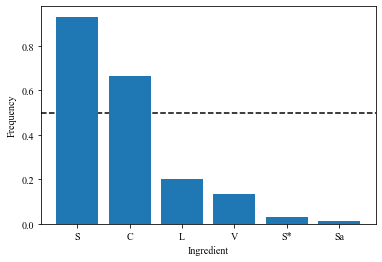

In [73]:
plt.bar(["S", "C", "L", "V", "S*", "Sa"], h, zorder=2)
plt.axhline(0.5, c="black", ls="--", zorder=1)
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.savefig("figures/ingredients_seperated.pdf", bbox_inches="tight")
plt.show()

In [74]:
X_train.loc[index_missing_train, ["sugar", "cocoa_butter"]] = 1
X_val.loc[index_missing_val, ["sugar", "cocoa_butter"]] = 1
X_test.loc[index_missing_test, ["sugar", "cocoa_butter"]] = 1

### Transform number of ingredients

In [75]:
num_ingr = X_train["number_ingredients"]

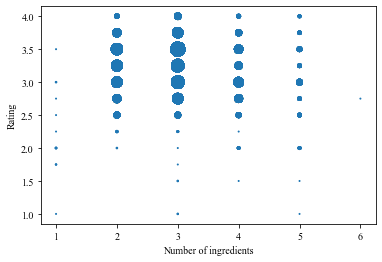

In [76]:
scatter_with_dot_size(num_ingr, y_train)
plt.xlabel("Number of ingredients")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_number_ingredients.pdf", bbox_inches="tight")
plt.show()

In [77]:
num_ingr_scaled = (num_ingr - num_ingr.mean()) / num_ingr.std()

In [78]:
print("raw: \t", num_ingr_scaled.corr(y_train))
print("abs: \t", abs(num_ingr_scaled).corr(y_train))
print("^2: \t", (num_ingr_scaled**2).corr(y_train))
print("^4: \t", (num_ingr_scaled**4).corr(y_train))    
print("exp: \t", num_ingr_scaled.apply(lambda x: math.exp(x)).corr(y_train))

raw: 	 -0.05651595085068437
abs: 	 -0.12671139067150586
^2: 	 -0.13996002920752337
^4: 	 -0.13239653849806676
exp: 	 -0.09433699943030467


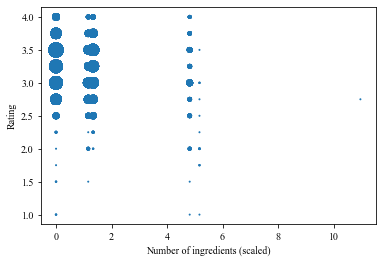

In [90]:
scatter_with_dot_size(num_ingr_scaled**2, y_train)
plt.xlabel("Number of ingredients (scaled)")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_number_ingredients_scaled.pdf", bbox_inches="tight")
plt.show()

In [80]:
X_train["number_ingredients_scaled"] = num_ingr_scaled**2

num_ingr_val = X_val["number_ingredients"]
X_val["number_ingredients_scaled"] = ((num_ingr_val - num_ingr_val.mean()) / num_ingr_val.std())**2

num_ingr_test = X_test["number_ingredients"]
X_test["number_ingredients_scaled"] = ((num_ingr_test - num_ingr_test.mean()) / num_ingr_test.std())**2

In [81]:
features_dict["ingredients"]["number_scaled"] = "number_ingredients_scaled"

## Most memorable characteristics

In [82]:
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [83]:
# load pretrained model
model_url = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
#model_url = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
embed = hub.load(model_url)

In [84]:
# apply pretrained text embedding
flavours_embedded_train = embed(X_train_raw["most_memorable_characteristics"])
flavours_embedded_val = embed(X_val_raw["most_memorable_characteristics"])
flavours_embedded_test = embed(X_test_raw["most_memorable_characteristics"])

In [85]:
pca = PCA(n_components=250)
pca.fit(flavours_embedded_train)
evr_cum = pca.explained_variance_ratio_.cumsum()

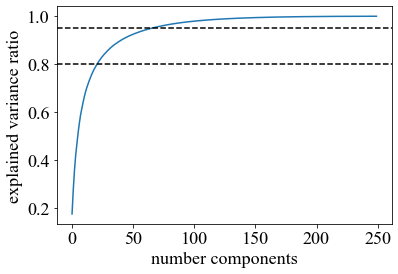

In [93]:
plt.plot(evr_cum)
plt.axhline(0.8, c="black", ls="--")
plt.axhline(0.95, c="black", ls="--")
plt.xlabel("number components")
plt.ylabel("explained variance ratio")
plt.show()

In [87]:
for ratio in [0.5, 0.8, 0.95]:
    i = np.min(np.where(evr_cum >= ratio))
    print(
        f"The first {i+1} components explain {round(evr_cum[i]*100,2)}% of the variance."
    )

The first 6 components explain 51.47% of the variance.
The first 22 components explain 80.46% of the variance.
The first 67 components explain 95.12% of the variance.


In [88]:
dim = np.min(np.where(evr_cum >= 0.95)) + 1

In [89]:
pca = PCA(n_components=dim)
flavours_pca_train = pca.fit_transform(flavours_embedded_train)
flavours_pca_val = pca.transform(flavours_embedded_val)
flavours_pca_test = pca.transform(flavours_embedded_test)
flavours_pca_test.shape

(389, 67)

# Indices korrigieren!!!

In [96]:
col_names = ["flavour" + str(i + 1) for i in range(dim)]

In [98]:
X_train.loc[:, col_names] = pd.DataFrame(flavours_pca_train, columns=col_names, index=X_train.index)
X_val.loc[:, col_names] = pd.DataFrame(flavours_pca_val, columns=col_names, index=X_val.index)
X_test.loc[:, col_names] = pd.DataFrame(flavours_pca_test, columns=col_names, index=X_test.index)

In [99]:
features_dict["most_memorable_characteristics"]["50%"] = [
    "flavour" + str(i + 1) for i in range(np.min(np.where(evr_cum >= 0.5)) + 1)
]
features_dict["most_memorable_characteristics"]["80%"] = [
    "flavour" + str(i + 1) for i in range(np.min(np.where(evr_cum >= 0.80)) + 1)
]
features_dict["most_memorable_characteristics"]["95%"] = [
    "flavour" + str(i + 1) for i in range(np.min(np.where(evr_cum >= 0.95)) + 1)
]

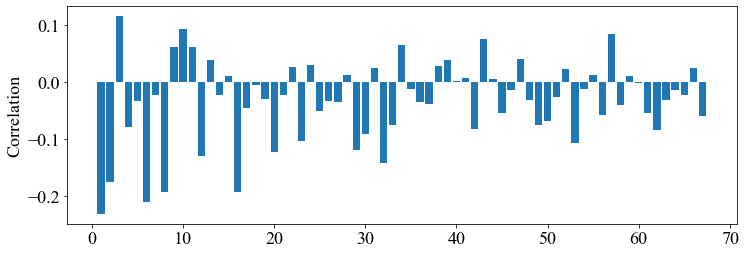

In [101]:
corr = X_train.loc[:, col_names].apply(y_train.corr)
plt.subplots(figsize=(12,4))
plt.bar(range(1,68), corr)
plt.ylabel("Correlation")
plt.show()

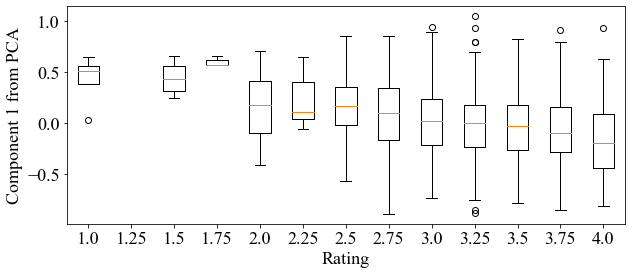

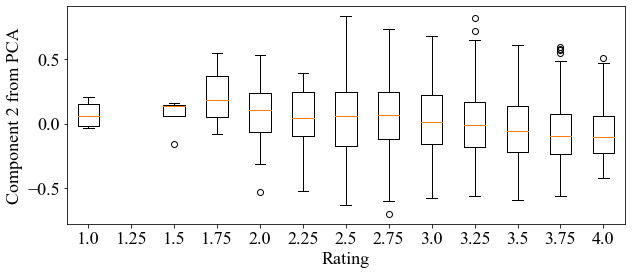

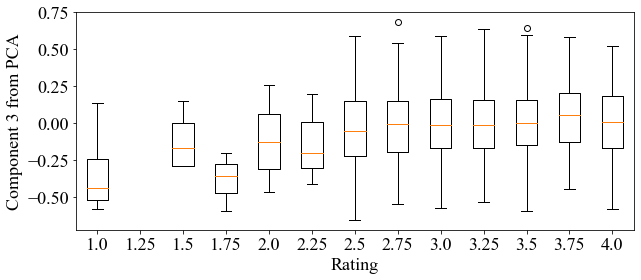

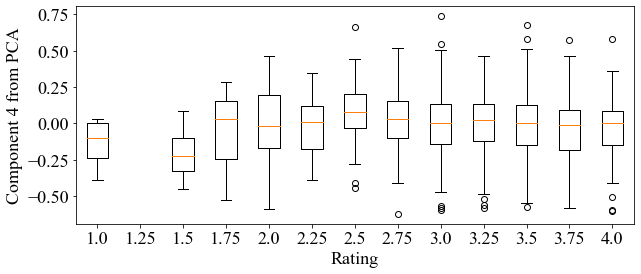

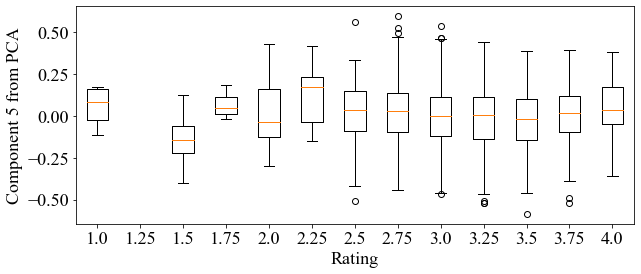

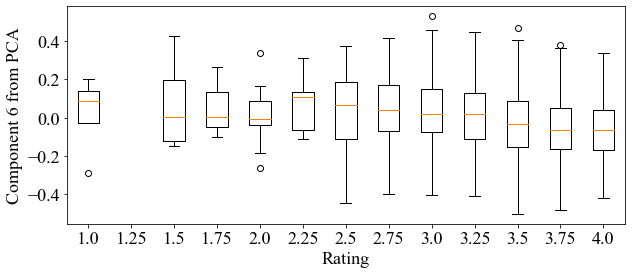

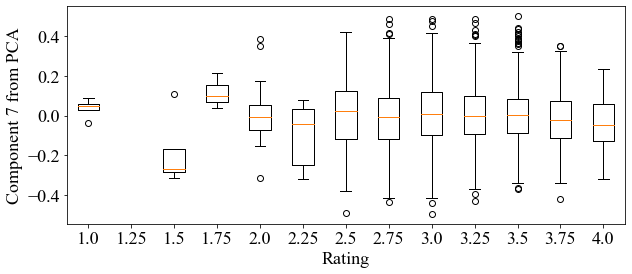

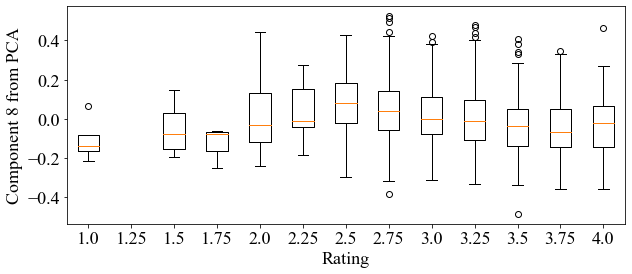

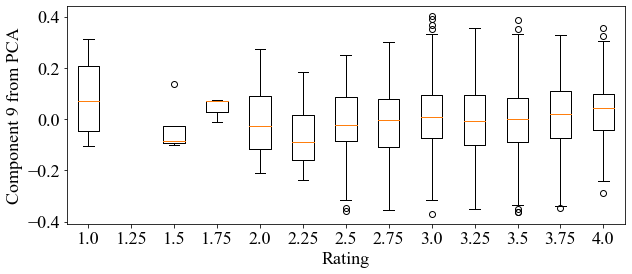

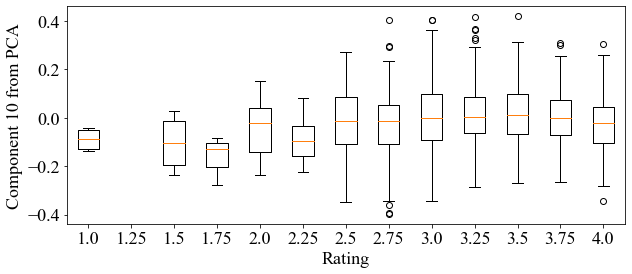

In [108]:
ratings = np.arange(1,4.25,0.25)
for i in range(1,11):
    plt.subplots(figsize=(10,4))
    plt.boxplot([X_train.loc[y_train==r,"flavour"+str(i)] for r in ratings], labels = ratings)
    plt.xlabel("Rating")
    plt.ylabel(f"Component {i} from PCA")
    plt.show()

## Cocoa percent

In [295]:
x = X_train["cocoa_percent"]

In [296]:
print("raw: \t", x.corr(y_train))
print("^2: \t", (x**2).corr(y_train))
print("^3: \t", (x**3).corr(y_train))
print("^4: \t", (x**4).corr(y_train))
print("exp: \t", x.apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", x.apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.135177792630391
^2: 	 -0.151207676165763
^3: 	 -0.16546802676188602
^4: 	 -0.17760685052439226
exp: 	 -0.14732450430840074
log: 	 -0.11778575497479639


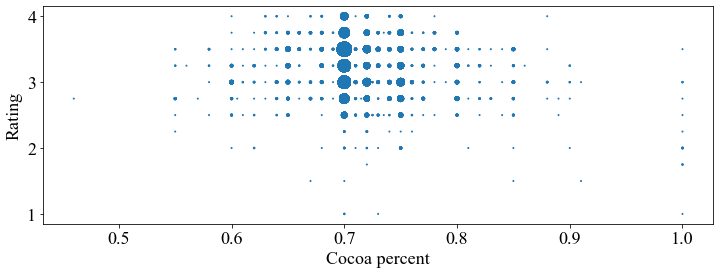

In [297]:
c = Counter(zip(x, y_train))
s = [c[(n, r)] for n, r in zip(x, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x, y_train, marker="o", s=s)
plt.xlabel("Cocoa percent")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_cocoa_percent.pdf", bbox_inches="tight")
plt.show()

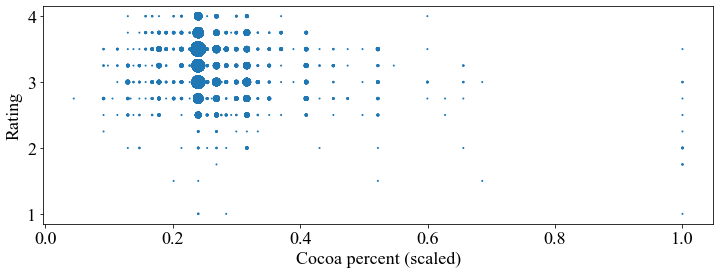

In [298]:
x_scaled = x**4
c = Counter(zip(x_scaled, y_train))
s = [c[(n, r)] for n, r in zip(x_scaled, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x_scaled, y_train, marker="o", s=s)
plt.xlabel("Cocoa percent (scaled)")
plt.ylabel("Rating")
# plt.savefig("figures/rating_vs_cocoa_percent.pdf", bbox_inches="tight")
plt.show()

# Benchmark Models

## Simple Median Model

In [198]:
class simple_median_model:
    median = None

    def fit(self, X=None, y=None):
        self.median = y.median()

    def predict(self, X):
        return np.repeat(self.median, X.shape[0])

In [199]:
median_model = simple_median_model()
median_model.fit(y=y_train)
print_scores(median_model.predict(X_train), median_model.predict(X_test))

MSE:		 Train: 0.1967 	Test: 0.1992
MdAE:		 Train: 0.2500 	Test: 0.2500
Accuracy:	 Train: 0.1825 	Test: 0.1825


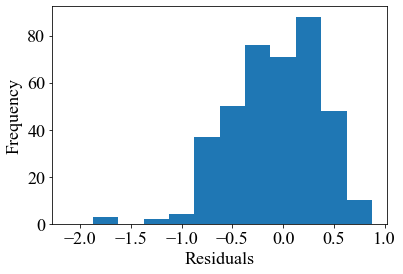

In [200]:
histogram_residuals(y_test, median_model.predict(X_test), "simple_median_model")

## Baseline Regression Model

In [201]:
baseline_predictors = ["review_date", "cocoa_percent", "number_ingredients"]

In [202]:
X_train_bl = X_train.loc[:, baseline_predictors]
X_test_bl = X_test.loc[:, baseline_predictors]

In [203]:
X_train_bl.apply(y_train.corr)

review_date           0.114318
cocoa_percent        -0.135178
number_ingredients   -0.056516
dtype: float64

In [204]:
bl = LinearRegression()
bl.fit(X_train_bl, y_train)
print_scores(bl.predict(X_train_bl), bl.predict(X_test_bl))

MSE:		 Train: 0.1879 	Test: 0.1876
MdAE:		 Train: 0.2879 	Test: 0.2924
Accuracy:	 Train: 0.1990 	Test: 0.2134


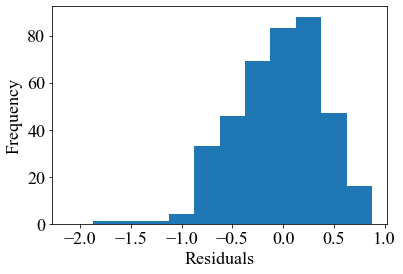

In [205]:
histogram_residuals(y_test, bl.predict(X_test_bl), "linear_regression")

# Linear Regression

## Stepwise add features

In [299]:
def linear_regression(cols):
    X_train_ = X_train.loc[:, cols]
    X_test_ = X_test.loc[:, cols]
    
    lr_ = LinearRegression()
    lr_.fit(X_train_, y_train)
    print_scores(lr_.predict(X_train_), lr_.predict(X_test_))

In [300]:
features_dict["baseline"]

['cocoa_percent', 'number_ingredients', 'review_date']

In [301]:
cols = features_dict["baseline"]
linear_regression(cols)

MSE:		 Train: 0.1879 	Test: 0.1876
MdAE:		 Train: 0.2879 	Test: 0.2924
Accuracy:	 Train: 0.1990 	Test: 0.2134


In [302]:
cols = features_dict["baseline"].copy()
for col in features_dict["one_hot_encoded"].keys():
    cols += features_dict["one_hot_encoded"][col]
cols
linear_regression(cols)

MSE:		 Train: 0.1766 	Test: 0.1832
MdAE:		 Train: 0.2882 	Test: 0.2972
Accuracy:	 Train: 0.2076 	Test: 0.2031


In [303]:
cols = features_dict["baseline"] + features_dict["ingredients"]["dummies"]
linear_regression(cols)

MSE:		 Train: 0.1818 	Test: 0.1752
MdAE:		 Train: 0.2754 	Test: 0.2734
Accuracy:	 Train: 0.2087 	Test: 0.2108


In [310]:
cols = features_dict["baseline"] + features_dict["most_memorable_characteristics"]["80%"]
linear_regression(cols)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [331]:
cols = scaled_numeric_cols + ingr_number_scaled_col + ingr_dummy_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1062 , Valid: 0.0737
MSE:				 Valid: 0.1829
Accuracy:	 Train: 0.2019 , Valid: 0.2452

Decision Tree Classifier:
Accuracy:	 Train: 0.2966 , Valid: 0.2201


## Full model

In [332]:
import statsmodels.api as sm

In [339]:
regressors_lr = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca80_cols
)
print(regressors_lr)

['review_date_01', 'cocoa_percent_p4', 'no_ingredients_exp', 'sugar', 'sweetener', 'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat', 'manufac_A. Morin', 'loc_U.S.A.', 'loc_France', 'loc_Canada', 'loc_U.K.', 'loc_Italy', 'loc_Belgium', 'loc_Ecuador', 'loc_Australia', 'org_Venezuela', 'org_Peru', 'org_Dominican Republic', 'org_Ecuador', 'org_Madagascar', 'org_Blend', 'org_Nicaragua', 'org_Brazil', 'org_Colombia', 'org_Tanzania', 'org_Bolivia', 'org_Belize', 'org_Vietnam', 'org_Guatemala', 'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4', 'flavour5', 'flavour6', 'flavour7', 'flavour8', 'flavour9', 'flavour10', 'flavour11', 'flavour12', 'flavour13', 'flavour14', 'flavour15', 'flavour16', 'flavour17', 'flavour18', 'flavour19', 'flavour20', 'flavour21', 'flavour22']


In [340]:
X_train_lr = X_train.loc[:, regressors_lr]
X_test_lr = X_test.loc[:, regressors_lr]

In [341]:
lr = LinearRegression()
lr.fit(X_train_lr, y_train)
print_scores(lr, X_train_lr, X_test_lr)

R^2:		 Train: 0.3813 , Valid: 0.2975
MSE:				 Valid: 0.1387
Accuracy:	 Train: 0.2812 , Valid: 0.2703


with scaled_numeric_cols, ingr_seperated_cols, location_dummy_cols (5%), origin_dummy_cols (5%) only: $\newline$
Train R2 =  0.11503917722373813 , Valid R2 =  0.057128032451005284 , Valid MSE =  0.19577608470025032

In [186]:
X = sm.add_constant(X_train_lr)
est = sm.OLS(y_train, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     21.09
Date:                Wed, 29 Jun 2022   Prob (F-statistic):          5.50e-161
Time:                        09:21:50   Log-Likelihood:                -778.06
No. Observations:                2070   AIC:                             1670.
Df Residuals:                    2013   BIC:                             1991.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

## Backward Elimination

In [187]:
est = sm.OLS(y_train, X).fit()
p = est.pvalues.max()
drop_cols = []

while p > 0.1:
    drop = est.pvalues[est.pvalues==p].index.to_list()
    print("drop:", drop)
    
    drop_cols = drop_cols + drop
    X_reduced = X.loc[:, ~X.columns.isin(drop_cols)]
    est = sm.OLS(y_train, X_reduced).fit()
    
    p = est.pvalues.max()

drop: ['loc_Canada']
drop: ['org_Bolivia']
drop: ['org_Tanzania']
drop: ['flavour18']
drop: ['org_Nicaragua']
drop: ['org_Colombia']
drop: ['loc_France']
drop: ['flavour7']
drop: ['org_Peru']
drop: ['no_ingredients_exp']
drop: ['org_Blend']
drop: ['loc_Italy']
drop: ['org_Vietnam']
drop: ['flavour9']
drop: ['salt']
drop: ['org_Belize']
drop: ['flavour14']
drop: ['flavour11']
drop: ['cocoa_butter']
drop: ['org_Dominican Republic']
drop: ['org_Madagascar']
drop: ['lecithin']
drop: ['org_Guatemala']
drop: ['flavour19']
drop: ['loc_U.K.']


In [188]:
X_train_reduced = X_train_lr.loc[:, ~X_train_lr.columns.isin(drop_cols)]
X_test_reduced = X_test_lr.loc[:, ~X_test_lr.columns.isin(drop_cols)]
print(X_train_reduced.columns)

Index(['review_date_01', 'cocoa_percent_p4', 'sugar', 'sweetener', 'vanilla',
       'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat',
       'manufac_A. Morin', 'loc_U.S.A.', 'loc_Belgium', 'loc_Ecuador',
       'loc_Australia', 'org_Venezuela', 'org_Ecuador', 'org_Brazil',
       'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4',
       'flavour5', 'flavour6', 'flavour8', 'flavour10', 'flavour12',
       'flavour13', 'flavour15', 'flavour16', 'flavour17'],
      dtype='object')


In [189]:
lr_reduced = LinearRegression()
lr_reduced.fit(X_train_reduced, y_train)
print_scores(lr_reduced, X_train_reduced, X_test_reduced)

R^2:		 Train: 0.3622 , Valid: 0.2668
MSE:				 Valid: 0.1448
Accuracy:	 Train: 0.2763 , Valid: 0.2587


## Lasso

In [342]:
from sklearn.linear_model import Lasso

In [352]:
regressors_clf = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + ingr_dummy_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca95_cols
)

In [353]:
X_train_clf = X_train.loc[:, regressors_clf]
X_test_clf = X_test.loc[:, regressors_clf]

In [354]:
clf = Lasso(alpha=0.001)
clf.fit(X_train_clf, y_train)
print_scores(clf, X_train_clf, X_test_clf)

R^2:		 Train: 0.4241 , Valid: 0.3443
MSE:				 Valid: 0.1295
Accuracy:	 Train: 0.2889 , Valid: 0.2934


In [355]:
alphas = np.arange(5e-05, 1e-03, 1e-05)
lasso_score = []
lasso_mse = []

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_train_clf, y_train)
    score_ = clf.score(X_test_clf, y_test)
    lasso_score.append(score_)
    mse_ = mse(clf.predict(X_test_clf), y_test)
    lasso_mse.append(mse_)

C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-02, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

In [356]:
lasso_score_df = pd.DataFrame({"alpha": alphas, "score": lasso_score})
lasso_score_df.loc[lasso_score_df["score"]==lasso_score_df["score"].max(), "alpha"]

1    0.00006
Name: alpha, dtype: float64

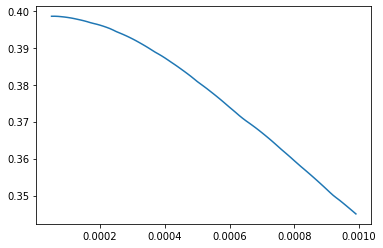

In [357]:
plt.plot(alphas, lasso_score)

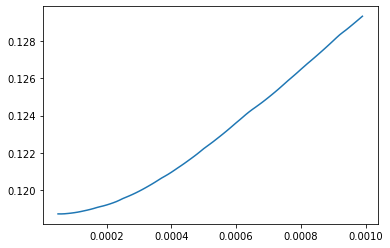

In [358]:
plt.plot(alphas, lasso_mse)

In [360]:
clf = Lasso(alpha=0.00006)
clf.fit(X_train_clf, y_train)
print_scores(clf, X_train_clf, X_test_clf)

R^2:		 Train: 0.5005 , Valid: 0.3985
MSE:				 Valid: 0.1187
Accuracy:	 Train: 0.3425 , Valid: 0.3205


C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-02, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(


# Pure text embedding model

Predict the rating using the column "most_memorable_characteristics" only.

In [193]:
import tensorflow as tf

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.1
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [203]:
model_url = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
hub_layer = hub.KerasLayer(model_url, input_shape=[], dtype=tf.string, trainable=False)

In [271]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 250)               252343750 
                                                                 
 dense_8 (Dense)             (None, 16)                4016      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 252,347,783
Trainable params: 4,033
Non-trainable params: 252,343,750
_________________________________________________________________


In [272]:
model.compile(
    optimizer="adam",
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError(name="MAE")],
)

In [273]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [274]:
fitted = model.fit(
    X_train["most_memorable_characteristics"],
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val["most_memorable_characteristics"], y_val),
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/200
30/30 [==============================] - 1s 21ms/step - loss: 6.7317 - MAE: 2.5249 - val_loss: 3.2452 - val_MAE: 1.7279
Epoch 2/200
30/30 [==============================] - 0s 15ms/step - loss: 1.6393 - MAE: 1.1097 - val_loss: 0.5850 - val_MAE: 0.6135
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 0.5477 - MAE: 0.5825 - val_loss: 0.4867 - val_MAE: 0.5496
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.4916 - MAE: 0.5486 - val_loss: 0.4525 - val_MAE: 0.5298
Epoch 5/200
30/30 [==============================] - 0s 14ms/step - loss: 0.4595 - MAE: 0.5300 - val_loss: 0.4375 - val_MAE: 0.5187
Epoch 6/200
30/30 [==============================] - 0s 14ms/step - loss: 0.4384 - MAE: 0.5168 - val_loss: 0.4246 - val_MAE: 0.5101
Epoch 7/200
30/30 [==============================] - 0s 14ms/step - loss: 0.4218 - MAE: 0.5061 - val_loss: 0.4142 - val_MAE: 0.5033
Epoch 8/200
30/30 [==============================] - 0s 14ms/step - loss: 0.

Epoch 63/200
30/30 [==============================] - 0s 3ms/step - loss: 0.1075 - MAE: 0.2578 - val_loss: 0.1409 - val_MAE: 0.2829
Epoch 64/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1064 - MAE: 0.2558 - val_loss: 0.1384 - val_MAE: 0.2831
Epoch 65/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1057 - MAE: 0.2545 - val_loss: 0.1380 - val_MAE: 0.2812
Epoch 66/200
30/30 [==============================] - 0s 3ms/step - loss: 0.1072 - MAE: 0.2567 - val_loss: 0.1393 - val_MAE: 0.2815
Epoch 67/200
30/30 [==============================] - 0s 3ms/step - loss: 0.1050 - MAE: 0.2537 - val_loss: 0.1406 - val_MAE: 0.2892
Epoch 68/200
30/30 [==============================] - 0s 3ms/step - loss: 0.1041 - MAE: 0.2518 - val_loss: 0.1381 - val_MAE: 0.2807
Epoch 69/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1037 - MAE: 0.2518 - val_loss: 0.1362 - val_MAE: 0.2808
Epoch 70/200
30/30 [==============================] - 0s 3ms/step - loss:

In [275]:
MAE = fitted.history['MAE']
val_MAE = fitted.history['val_MAE']
loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

epochs = range(1, len(MAE) + 1)

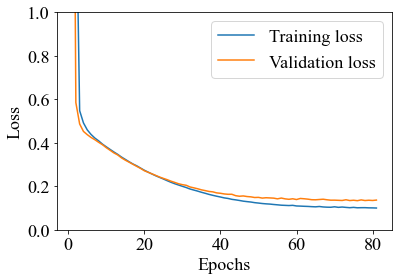

In [276]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

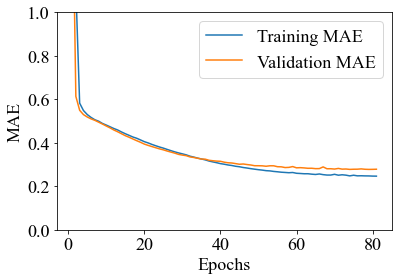

In [277]:
plt.plot(epochs, MAE, label='Training MAE')
plt.plot(epochs, val_MAE, label='Validation MAE')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [278]:
y_pred_train = model.predict(X_train["most_memorable_characteristics"], verbose=False).reshape(-1)
y_pred = model.predict(X_test["most_memorable_characteristics"], verbose=False).reshape(-1)

In [281]:
14.90 + 29.25 + 128.39

172.54

In [279]:
print_scores(y_pred_train, y_pred)

MSE:		 Train: 0.1002 	Test: 0.1130
MdAE:		 Train: 0.2091 	Test: 0.2105
Accuracy:	 Train: 0.3162 	Test: 0.3265


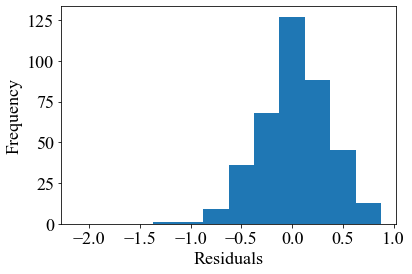

In [280]:
histogram_residuals(y_test, y_pred, "text_embedding")

# Old Code

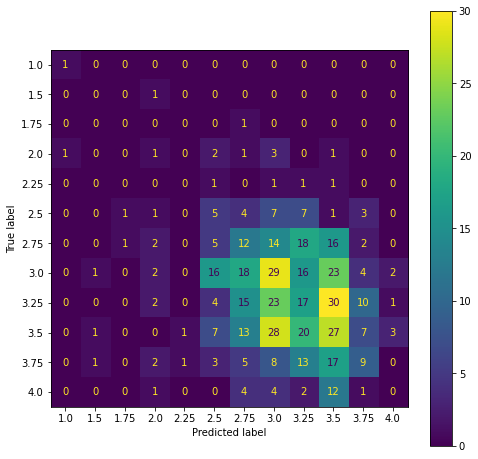

In [182]:
cm = confusion_matrix(y_test_cat, y_pred_dtc)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm, display_labels=dtc.classes_)
disp.plot(ax=ax)
plt.show()

# Random Forests

In [361]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [367]:
regressors_rf = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + ingr_dummy_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca95_cols
)

In [368]:
X_train_rf = X_train.loc[:, regressors_rf]
X_test_rf = X_test.loc[:, regressors_rf]

In [364]:
dt = DecisionTreeRegressor(min_samples_leaf=100)
dt.fit(X_train_rf, y_train)
print_scores(dt, X_train_rf, X_test_rf)

R^2:		 Train: 0.2320 , Valid: 0.0938
MSE:				 Valid: 0.1789
Accuracy:	 Train: 0.2536 , Valid: 0.2336


In [369]:
rf = RandomForestRegressor(min_samples_leaf=50, max_depth=5, random_state=42)
rf.fit(X_train_rf, y_train)
print_scores(rf, X_train_rf, X_test_rf)

R^2:		 Train: 0.3314 , Valid: 0.2135
MSE:				 Valid: 0.1553
Accuracy:	 Train: 0.2493 , Valid: 0.2606


In [201]:
fi_df = pd.DataFrame(
    data={'Feature': X_train_rf.columns, 'Feature importance': rf.feature_importances_}, 
    columns = ['Feature', 'Feature importance']
)
fi_df.sort_values('Feature importance', inplace=True, ascending=False)

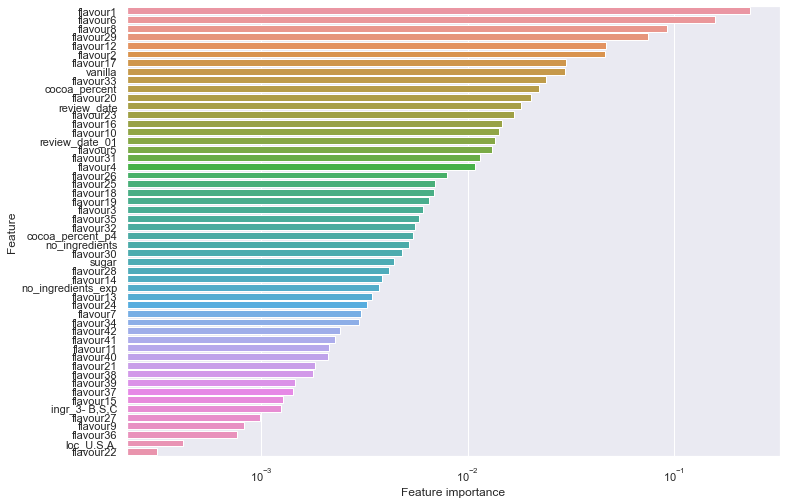

In [202]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=fi_df[fi_df["Feature importance"] > 0], x='Feature importance', y='Feature')
plt.xscale('log')

In [203]:
per_imp = permutation_importance(rf, X_train_rf, y_train, n_repeats=1, n_jobs=-1)
pi_df = pd.DataFrame(
    data={'Feature': X_train_rf.columns, 'Permutation importance': per_imp["importances_mean"]}, 
    columns = ['Feature', 'Permutation importance']
)
pi_df.sort_values('Permutation importance', inplace=True, ascending=False)

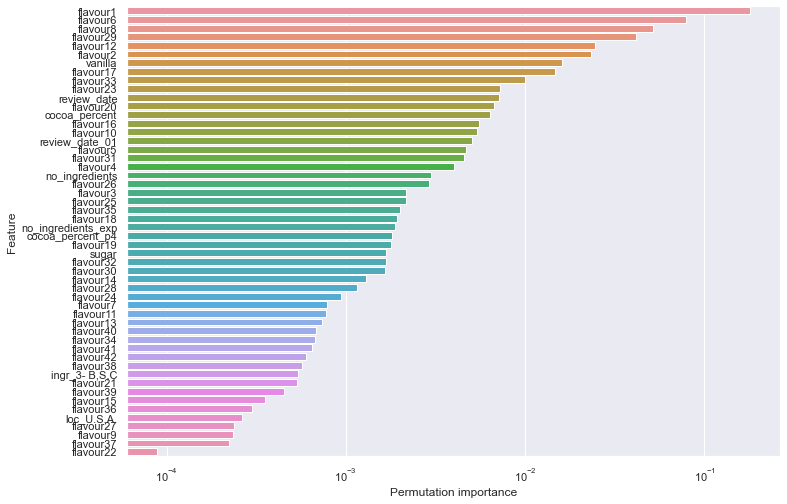

In [204]:
sns.barplot(data=pi_df[pi_df["Permutation importance"] > 0], x='Permutation importance', y='Feature')
plt.xscale('log')

In [205]:
regressors_lr_fi = list(
    set(fi_df[fi_df["Feature importance"] > 0].Feature).intersection(
        pi_df[pi_df["Permutation importance"] > 0].Feature
    )
)
regressors_lr_fi

['flavour3',
 'flavour21',
 'cocoa_percent',
 'flavour23',
 'flavour2',
 'flavour40',
 'flavour13',
 'loc_U.S.A.',
 'ingr_3- B,S,C',
 'review_date_01',
 'flavour38',
 'review_date',
 'flavour12',
 'flavour42',
 'flavour31',
 'flavour15',
 'flavour18',
 'flavour36',
 'no_ingredients_exp',
 'flavour41',
 'flavour27',
 'flavour33',
 'flavour8',
 'flavour26',
 'flavour29',
 'flavour19',
 'flavour4',
 'flavour24',
 'sugar',
 'flavour14',
 'flavour10',
 'flavour5',
 'vanilla',
 'cocoa_percent_p4',
 'flavour39',
 'flavour37',
 'flavour22',
 'flavour32',
 'flavour25',
 'flavour16',
 'flavour7',
 'flavour9',
 'flavour6',
 'flavour11',
 'flavour20',
 'flavour30',
 'flavour1',
 'flavour28',
 'flavour17',
 'no_ingredients',
 'flavour34',
 'flavour35']

In [206]:
# repeat linear regression with features selected by importance in random forest
X_train_lr_fi = X_train.loc[:, regressors_lr_fi]
X_test_lr_fi = X_test.loc[:, regressors_lr_fi]

lr_reduced = LinearRegression()
lr_reduced.fit(X_train_lr_fi, y_train)
print_scores(lr_reduced, X_train_lr_fi, X_test_lr_fi)

R^2:		 Train: 0.4302 , Valid: 0.3663
MSE:				 Valid: 0.1251
Accuracy:	 Train: 0.3005 , Valid: 0.2915
